## Introduction and Motivation
This problem dataset was taken from Kaggle website under the name "Amazon Fine Food Reviews". The motivation was to have an hands-on experience with a good Natural Language Processing problem along with sentiment analysis. Using the analysis in this work, a prediction model can be made to predict a recommendation/sentiment as either positive or negative.

## Problem Context
The dataset used in this exercise was taken from Kaggle website. The dataset consists of ~500,000 reviews that were submitted over a span of more than 10 years. These reviews includes product and user information, ratings, and text review. Moreover, reviews from all other Amazon categories are also included.

#### Importing useful libraries and data  

In [218]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import sqlite3
import os
from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import accuracy_score,f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import time
import re

In [219]:
df_temp=pd.read_csv('Reviews.csv')
df_temp.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


The dataset contains many columns such as "Id", "ProductId", "UserId" "ProfileName" and "Time" which might be useful for some exploratory analysis along based on specific users and their preferences for some particular product type. For the purpose of text classification task where a particular review will be classified as either a "Positive" class or a "Negative" class, these columns are of not much use. 

Therefore, for our text classification task of a review, we will try to use supervised learning where we will use "Summary" columns as our features and "Score" columns as class labels. We could have used the "Text" column as well along with "Summary" column  which contains a more detailed review for a particluar product for a better analysis but I will go on with only "Summary" as of now. Moreover, for simplicity purpose, we will convert our Scores as "positive" for scores higher than or equal to 3 and "negative" to all cases otherwise. This is make this classification problem from mulitclass classification to binary classification problem. 

In [220]:
df=df_temp.iloc[:,[6,8]]
df.head(10)

,Score,Summary
0,5,Good Quality Dog Food
1,1,Not as Advertised
2,4,"""Delight"" says it all"
3,2,Cough Medicine
4,5,Great taffy
5,4,Nice Taffy
6,5,Great! Just as good as the expensive brands!
7,5,"Wonderful, tasty taffy"
8,5,Yay Barley
9,5,Healthy Dog Food


Let's define a function to takes scores ranging from 1 to 5 and returns them as positive or negative score as discussed earlier.

In [221]:
def review(x):
    if x<3:
        return 'negative'
    return 'positive'

For the purpose of training a supervised learning algorithm on our data, we first need to separate our data in features and labels.

In [222]:
Score=df['Score']
Score=Score.map(review)
Summary=df['Summary']


Also, let's split our data in training and test datasets with 80% for the purpose of training and 20% for the purpose of validating our models. For this, we will use Scikit-learn train_test_split method.

In [213]:
Score=df['Score']
Score=Score.map(review)
Summary=df['Summary']
X_train,X_test,y_train,y_test=train_test_split(Summary,Score,
                                               test_size=0.2,
                                               random_state=42)

In [223]:
df['Score']=df['Score'].map(review)
print(df.head(20))

       Score                                            Summary
0   positive                              Good Quality Dog Food
1   negative                                  Not as Advertised
2   positive                              "Delight" says it all
3   negative                                     Cough Medicine
4   positive                                        Great taffy
5   positive                                         Nice Taffy
6   positive      Great!  Just as good as the expensive brands!
7   positive                             Wonderful, tasty taffy
8   positive                                         Yay Barley
9   positive                                   Healthy Dog Food
10  positive                    The Best Hot Sauce in the World
11  positive  My cats LOVE this "diet" food better than thei...
12  negative               My Cats Are Not Fans of the New Food
13  positive                                  fresh and greasy!
14  positive                       Straw

C:\Users\yarathor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


We have now transformed our integer score as an opinion: positive or negative.

### Are the classes balanced?

Lets plot number of scores in each class, namely positive and negative. This will give us an idea of the distribution of classes in our dataset.

Counter({'positive': 486417, 'negative': 82037})


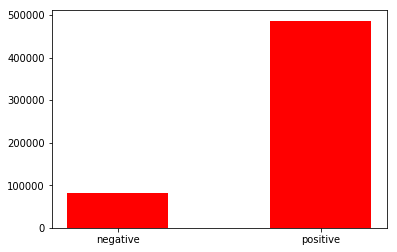

In [224]:
scores = list(df['Score'])
freqs = Counter(scores)
print (freqs)
x = list(freqs.keys())
y = list(freqs.values())
width = 1/2.0
plt.bar( x, y, width ,color="red" )
plt.show()

It seems that the classes for this problem are imbalanced in nature. Hence only predicting accuracy for a particular class might not be good measure to predict model performance. Hence, while building our models, we need to make sure that that we employ other performance metrics such as f1_score which is the weighted average of precision and recall and confusion matrix to get better insight than traditional accuracy metric.

### Wordclouds

Next we can plot some wordcloud from our positive and negative class and see which words occur in greater frequency. Plotting wordcloud gives an interesting insight and can tell us what words can better describe a review as a positive or a negative feedback. However, it should be noted that users generally use many stopwords which occur more frequently and don't give too much information for our analysis. Hence we will perform some cleaning to make sure only meaningful words appear in our wordclouds.

Positive Word Cloud


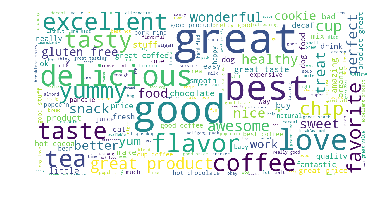

Negative Word-Cloud


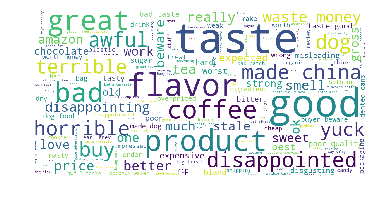

In [225]:
review_pos = ''
review_neg = ''

df_temp2 = df_temp
df_temp2['Score'] = df_temp2['Score'].map(review)

intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

pos_words = df_temp2.loc[df_temp2['Score'] == 'positive']
pos_words = pos_words[0:10000]

for val in pos_words['Summary']:
    if(type(val)==str):
        text = val.lower()
        text = text.translate(trantab)
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        for words in tokens:
            review_pos = review_pos + words + ' '

print('Positive Word Cloud')
wordcloud_pos = WordCloud(background_color='white',
                         scale=3,max_font_size=50,
                         random_state=1).generate(review_pos)
plt.figure()
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.show()



print ('Negative Word-Cloud')
neg = df_temp.loc[df_temp['Score'] == 'negative']
neg = neg[0:10000]

for val in neg['Summary']:
    if(type(val)==str):
        text = val.lower()
        text = text.translate(trantab)
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        for words in tokens:
            negative_words = negative_words + words + ' '

            
wordcloud_neg= WordCloud(background_color='white',
                         scale=3,max_font_size=50,
                         random_state=1).generate(negative_words)

        
plt.figure()
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.show()

By looking at our wordclouds for positive and negative reviews, we see that words like 'great', 'best', 'delicious', 'good',  'love', 'excellent' etc are used very commonly for positive reviews. In contrast, 'bad', 'horrible', 'disappointed', 'yuck', 'awful' etc. are more frequently used words for negative samples.

### Cleaning and Preprocessing the data

We can see in our "Summary" column that users have submitted their reviews in various styles using upper-case and punctuations. We need to process them to a common (lower-case) case. The purpose for doing this is to make the models interprets "great" and "GREAT" as a same entity. We will use python re module to get rid of punctuations and upper-case letters from our summary.

In [228]:
import re

def preprocessor(text):
    text=re.sub('<[^>]*>','',str(text))
    text = re.sub(r'\<a href', ' ',str(text))
    text = re.sub(r'&amp;', '', str(text))
    text=re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ',str(text))
    text = re.sub(r'\'', ' ', str(text))
    text=re.sub('[\W]+',' ',text.lower())
    return text


In [229]:
df['Summary']=df['Summary'].apply(preprocessor)

C:\Users\yarathor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [230]:
df.head(10)

,Score,Summary
0,positive,good quality dog food
1,negative,not as advertised
2,positive,delight says it all
3,negative,cough medicine
4,positive,great taffy
5,positive,nice taffy
6,positive,great just as good as the expensive brands
7,positive,wonderful tasty taffy
8,positive,yay barley
9,positive,healthy dog food


Next, we will utilize NLTK library to tokenize words, remove stopwords and perform stemming of words using PorterStemmer. 

In [231]:
def tokenizer(text):
    return text.split()

In [232]:
porter=PorterStemmer()

def tokenize_porter(text):
    return [porter.stem(word) for word in text.split() ]


We will create a separate (dummy) Summary column to see the results of our text preprocessing steps and to make sure our tokenizer and tokenize_porter functions are working as expected.

In [233]:
df['Summary1']=df['Summary'].apply(tokenizer)

C:\Users\yarathor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [234]:
df.head(10)

,Score,Summary,Summary1
0,positive,good quality dog food,"[good, quality, dog, food]"
1,negative,not as advertised,"[not, as, advertised]"
2,positive,delight says it all,"[delight, says, it, all]"
3,negative,cough medicine,"[cough, medicine]"
4,positive,great taffy,"[great, taffy]"
5,positive,nice taffy,"[nice, taffy]"
6,positive,great just as good as the expensive brands,"[great, just, as, good, as, the, expensive, br..."
7,positive,wonderful tasty taffy,"[wonderful, tasty, taffy]"
8,positive,yay barley,"[yay, barley]"
9,positive,healthy dog food,"[healthy, dog, food]"


In [235]:
df['Summary1']=df['Summary'].apply(tokenize_porter)

C:\Users\yarathor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [238]:
df.head(10)

,Score,Summary,Summary1
0,positive,good quality dog food,"[good, qualiti, dog, food]"
1,negative,not as advertised,"[not, as, advertis]"
2,positive,delight says it all,"[delight, say, it, all]"
3,negative,cough medicine,"[cough, medicin]"
4,positive,great taffy,"[great, taffi]"
5,positive,nice taffy,"[nice, taffi]"
6,positive,great just as good as the expensive brands,"[great, just, as, good, as, the, expens, brand]"
7,positive,wonderful tasty taffy,"[wonder, tasti, taffi]"
8,positive,yay barley,"[yay, barley]"
9,positive,healthy dog food,"[healthi, dog, food]"


In [239]:
stop=stopwords.words('english')

Everything seems to be working as expected. So let's proceed with our biulding our text classification models.

Text Mining and Classification task can be computationally  very expensive and generally with datasets like this, the computation time might limit us from trying various models for supervised learning. Hence, to address this issue, we will first try building sample models on a smaller subset and the model with best performance will then be scaled to entire dataset.    

In [240]:
df.shape

(568454, 3)

We have more than 560,000 entries for our entire dataset. Let's begin by selecting 50,000 rows selected at random in sample dataset. 

In [241]:
sampledf=df.sample(n=100000)
sampledf.reset_index(inplace=True)
sampledf

,index,Score,Summary,Summary1
0,379289,positive,fantastic food but why the price increase,"[fantast, food, but, whi, the, price, increas]"
1,186184,negative,made in china,"[made, in, china]"
2,250929,positive,decent tasting but some problems,"[decent, tast, but, some, problem]"
3,359677,positive,healthy at a great bargain,"[healthi, at, a, great, bargain]"
4,179794,positive,these are for dogs,"[these, are, for, dog]"
5,112533,positive,ice sparkling drink,"[ice, sparkl, drink]"
6,290845,positive,delightfully surprised,"[delight, surpris]"
7,3867,positive,one java pods,"[one, java, pod]"
8,211510,positive,like morning thunder tea,"[like, morn, thunder, tea]"
9,102007,positive,yummm sweet potatoes,"[yummm, sweet, potato]"


In [242]:
sampledf.shape

(100000, 4)

Next, we need to split our data in training and test datasets with 80% for the purpose of training and 20% for the purpose of validating our models. For this, we will use Scikit-learn train_test_split method.

In [243]:
Score=sampledf['Score']
Summary=sampledf['Summary']

X_train,X_test,y_train,y_test=train_test_split(Summary,Score,
                                               test_size=0.1,
                                               random_state=42)

In [244]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(90000,)
(10000,)
(90000,)
(10000,)


Now that everything is ready, let's start by building our first model using SVM. We will deploy grid search for finding some starting parameters related to TfIdfVectorizer and SVM classifier.

# Model-1 with SVM

In [51]:

tfidf=TfidfVectorizer(strip_accents=None,
                     lowercase=False,
                     preprocessor=None)

param_grid=[{'vect__ngram_range':[(1,1)],
            'vect__stop_words':[stop,None],
            'vect__tokenizer':[tokenizer,tokenize_porter],
            'clf__C':[1.0,10.0]}]


#Model-2 with SVM and tokenizer and tokenizer_porter in grid_search

svm_tfidf_1=Pipeline([('vect',tfidf),('clf',SVC(random_state=0))])

gs_svm_tfidf_1=GridSearchCV(svm_tfidf_1,param_grid,scoring='accuracy',
                            cv=4,verbose=1,n_jobs=1)

start=time.time()
gs_svm_tfidf_1.fit(X_train,y_train)
end=time.time()

print('Training Complete\n')
print('Best Parameter Set: %s'%gs_svm_tfidf_1.best_params_)
print('Time Taken : ',end-start,'sec')

prediction_svm_1=gs_svm_tfidf_1.predict(X_test)

print('Model_1-SVM Accu. Score : %.3f ' %(accuracy_score(y_test,prediction_svm_1)))
print('Model_1 F1 Score : %.3f ' %(f1_score(y_test,prediction_svm_1,average='micro')))
print('Model_1 Confusion Matrix\n' ,classification_report(y_test,prediction_svm_1))

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 106.5min finished


Training Complete

Best Parameter Set: {'clf__C': 1.0, 'vect__ngram_range': (1, 1), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'f

C:\Users\yarathor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LINEAR SVM MODEL-1 training complete........

The above model based on linear SVM gave us a classification accuracy score of about 86%.

Since most research papers have suggested using Bernoulli's Naive Bayes Classifier for text classification, let's give it a try to assess its performance with respect to linear SVM classifier. The reason for high popularity of NB models is that they are simple probablistic models which requires counts of words and n-grams in hash tables. Each word count is treated as separate feature and hence, the feature space consist of total number of distinct words in our entire training set.

# Model-2 with BernoulliNB

In [249]:

from sklearn.naive_bayes import BernoulliNB


tfidf=TfidfVectorizer(strip_accents=None,
                     lowercase=False,
                     preprocessor=None)

param_grid=[{'vect__ngram_range':[(1,1)],
             'vect__stop_words':[stop,None],
             'vect__tokenizer':[tokenizer,tokenize_porter]},
            {'vect__ngram_range':[(1,1)],
             'vect__stop_words':[stop,None],
             'vect__tokenizer':[tokenizer,tokenize_porter],
             'vect__use_idf':[False],
             'vect__norm':[None]}]



ber_nb_tfidf=Pipeline([('vect',tfidf),('clf',BernoulliNB())])

gs_nb_tfidf=GridSearchCV(ber_nb_tfidf,param_grid,scoring='accuracy',
                         cv=4,verbose=1,n_jobs=1)


start=time.time()
gs_nb_tfidf.fit(X_train,y_train)
end=time.time()
print('Best Parameter Set: %s'%gs_nb_tfidf.best_params_)
print('Time Taken : ',end-start,'sec')

prediction_bnb=gs_nb_tfidf.predict(X_test)

print('Model_1-SVM Accu. Score : %.3f ' %(accuracy_score(y_test,prediction_bnb,normalize=True)))
print('Model_1 F1 Score : %.3f ' %(f1_score(y_test,prediction_bnb,average='micro')))
print('Model_1 Confusion Matrix\n' ,classification_report(y_test,prediction_bnb))

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  2.4min finished


Best Parameter Set: {'vect__ngram_range': (1, 1), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'som

Slight increment in accuracy of approx. 3 percent when using Bernoulli Naive-Bayes. However, it should be noted that BernoulliNB is best suited for binary/boolean features as mentioned on scikit-learn documentation website. A more suitable classifier of text classification purpose is Multinomial Naive-Bayes which is suitable for classification with discrete features. Hence, keeping this is mind, let's give MultinomialNB a try and see if there are any performance gains over BernoulliNB and linearSVM.

# Model-3 with MultinomialNB

In [250]:

tfidf=TfidfVectorizer(strip_accents=None,
                     lowercase=False,
                     preprocessor=None)

param_grid=[{'vect__ngram_range':[(1,1)],
            'vect__stop_words':[stop,None],
            'vect__tokenizer':[tokenizer,tokenize_porter]},
            {'vect__ngram_range':[(1,1)],
            'vect__stop_words':[stop,None],             
            'vect__tokenizer':[tokenizer,tokenize_porter],
             'vect__use_idf':[False],
             'vect__norm':[None]}]



multi_nb_tfidf=Pipeline([('vect',tfidf),('clf',MultinomialNB())])

gs_mnb_tfidf=GridSearchCV(multi_nb_tfidf,param_grid,scoring='accuracy',
                        cv=3,verbose=1,n_jobs=1)

start=time.time()
gs_mnb_tfidf.fit(X_train,y_train)
end=time.time()

print('Training Complete\n')
print('Best Parameter Set: %s'%gs_mnb_tfidf.best_params_)
print('Time Taken : ',end-start,'sec')



prediction_Mnb_1=gs_mnb_tfidf.predict(X_test)

print('Model_1-SVM Accu. Score : %.3f ' %(accuracy_score(y_test,prediction_Mnb_1,normalize=True)))
print('Model_1 F1 Score : %.3f ' %(f1_score(y_test,prediction_Mnb_1,average='micro')))
print('Model_1 Confusion Matrix\n' ,classification_report(y_test,prediction_Mnb_1))


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.8min finished


Training Complete

Best Parameter Set: {'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x000002148CB3DBF8>, 'vect__use_idf': False}
Time Taken :  108.90017533302307 sec
Model_1-SVM Accu. Score : 0.894 
Model_1 F1 Score : 0.894 
Model_1 Confusion Matrix
              precision    recall  f1-score   support

   negative       0.71      0.51      0.59      1512
   positive       0.92      0.96      0.94      8488

avg / total       0.89      0.89      0.89     10000



As expected, MultinomialNB did worked slightly better than BernoulliNB but it should be noted that we are training our models using less than 10% of our total available data. Using all the available data is always advisable and can give far better results than above. We will try to build one last model using Logistic Regression since logistic regression is equally suggested for text classification tasks as naive-bayes and can perform even better than naive-bayes in some text-classification tasks.

# Model-4 using Log-Reg

In [251]:

tfidf=TfidfVectorizer(strip_accents=None,
                      lowercase=False,
                      preprocessor=None)

param_grid=[{'vect__ngram_range':[(1,1)],
            'vect__stop_words':[stop,None],
            'vect__tokenizer':[tokenizer,tokenize_porter],
            'clf__penalty':['l1','l2'],
            'clf__C':[1.0,10.0]},
           {'vect__ngram_range': [(1,1)],
            'vect__stop_words': [stop, None],
            'vect__tokenizer': [tokenizer,tokenize_porter],
            'vect__use_idf':[False],
            'vect__norm':[None],
            'clf__penalty': ['l1', 'l2'],
            'clf__C': [1.0, 10.0]}]
                
lr_tfidf=Pipeline([('vect',tfidf),
                   ('clf',LogisticRegression(random_state=0))])

gs_lr_tfidf=GridSearchCV(lr_tfidf,param_grid,
                         scoring='accuracy',
                         cv=4,verbose=1,n_jobs=1)

start=time.time()
gs_lr_tfidf.fit(X_train,y_train)
end=time.time()

print('Training Complete\n')
print('Best Parameter Set: %s'%gs_lr_tfidf.best_params_)
print('Time Taken : ',end-start,'sec')



Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed: 10.3min finished


Training Complete

Best Parameter Set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x000002148CB3DBF8>}
Time Taken :  619.936684846878 sec


In [252]:
prediction_lr=gs_lr_tfidf.predict(X_test)

print('Model_1-SVM Accu. Score : %.3f ' %(accuracy_score(y_test,prediction_lr,normalize=True)))
print('Model_1 F1 Score : %.3f ' %(f1_score(y_test,prediction_lr,average='micro')))
print('Model_1 Confusion Matrix\n' ,classification_report(y_test,prediction_lr))


Model_1-SVM Accu. Score : 0.904 
Model_1 F1 Score : 0.904 
Model_1 Confusion Matrix
              precision    recall  f1-score   support

   negative       0.75      0.55      0.64      1512
   positive       0.92      0.97      0.94      8488

avg / total       0.90      0.90      0.90     10000



We can see that Logistic Regression have performed by far better than all the models (LinearSVM, BernoulliNB, MutinominalNB). Hence we will finalize this project by training our Logistic Regression model over entire training data to achieve best performance.

In [253]:
df.shape

(568454, 3)

In [266]:
Score=df['Score']
Summary=df['Summary']

X_train,X_test,y_train,y_test=train_test_split(Summary,Score,
                                               test_size=0.1,
                                               random_state=42)


In [255]:

tfidf=TfidfVectorizer(strip_accents=None,
                      lowercase=False,
                      preprocessor=None)

param_grid=[{'vect__ngram_range':[(1,1)],
            'vect__stop_words':[stop,None],
            'vect__tokenizer':[tokenizer,tokenize_porter],
            'clf__penalty':['l1','l2'],
            'clf__C':[1.0,10.0]},
           {'vect__ngram_range': [(1,1)],
            'vect__stop_words': [stop, None],
            'vect__tokenizer': [tokenizer,tokenize_porter],
            'vect__use_idf':[False],
            'vect__norm':[None],
            'clf__penalty': ['l1', 'l2'],
            'clf__C': [1.0, 10.0]}]
                
lr_tfidf=Pipeline([('vect',tfidf),
                   ('clf',LogisticRegression(random_state=0))])

gs_lr_tfidf=GridSearchCV(lr_tfidf,param_grid,
                         scoring='accuracy',
                         cv=4,verbose=1,n_jobs=1)

start=time.time()
gs_lr_tfidf.fit(X_train,y_train)
end=time.time()

print('Training Complete\n')
print('Best Parameter Set: %s'%gs_lr_tfidf.best_params_)
print('Time Taken : ',end-start,'sec')



Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed: 63.8min finished


Training Complete

Best Parameter Set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x000002148CB3DBF8>}
Time Taken :  3847.5774631500244 sec


In [264]:
predictions_lr=gs_lr_tfidf.predict(X_test)

print('Model_4 Log-Reg Accu. Score : %.3f ' %(accuracy_score(y_test,predictions_lr,normalize=True)))
print('Model_4 F1 Score : %.3f ' %(f1_score(y_test,predictions_lr,average='micro')))
print('Model_4 Classification Report\n' ,classification_report(y_test,predictions_lr))


Model_4 Log-Reg Accu. Score : 0.917 
Model_4 F1 Score : 0.917 
Model_4 Classification Report
              precision    recall  f1-score   support

   negative       0.76      0.61      0.68      8083
   positive       0.94      0.97      0.95     48763

avg / total       0.91      0.92      0.91     56846



Looking at the results, we can see that logistic regression model performed better than the models tried previously with accuracy as high as ~92%. Lets plot the confusion matrix for this model to evaluate the quality of output of our model.

### Confusion Matrix

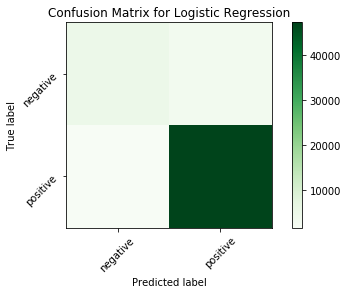

In [265]:

plt.imshow(confusion_matrix(y_test,predictions_lr),
           interpolation='nearest',cmap=plt.cm.Greens)
plt.title('Confusion Matrix for Logistic Regression')
plt.colorbar()
plt.xticks(np.arange(len(set(Score))), set(Score), rotation=45  )
plt.yticks(np.arange(len(set(Score))), set(Score),rotation=45  )
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
np.set_printoptions(precision=2)
plt.figure()

plt.show()